In [1]:
import os
import sys
import time
from naoqi import ALProxy
import numpy as np
import cv2
import time
from datetime import datetime
import os
# import pika #1.1.0
import base64
import time 
import yaml
import cv2
import requests
import json
import numpy as np

In [2]:
NAO_IP = "10.0.255.8"
NAO_PORT = 9559
PEPPER_IP = "10.0.52.247"
PEPPER_PORT = 9503

width = 1280
height = 960
channel = 3
 
fps = 30
sec = 5

In [3]:
def contours(image):
  # Convert the image to the HSV color space
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define the lower and upper range of red color in HSV
  lower_red = np.array([0, 100, 100])
  upper_red = np.array([10, 255, 255])

  # Create a mask to isolate the red regions
  mask = cv2.inRange(hsv, lower_red, upper_red)

  # Find the contours of the red regions
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Create a black image to use as a canvas
  red_areas = np.zeros_like(image)

  # Loop through the detected red regions and draw them on the canvas
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      red_areas[y:y+h, x:x+w] = image[y:y+h, x:x+w]


  return red_areas

In [4]:
def circle_detect(image):

  # Convert the image to the HSV color space
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define the lower and upper range of red color in HSV
  lower_red = np.array([0, 100, 100])
  upper_red = np.array([10, 255, 255])

  # Create a mask to isolate the red regions
  mask = cv2.inRange(hsv, lower_red, upper_red)

  # Apply Gaussian blur to reduce noise
  blurred = cv2.GaussianBlur(mask, (9, 9), 2)

  # Apply Hough Circle Transform
  circles = cv2.HoughCircles(
      blurred,
      cv2.HOUGH_GRADIENT,
      dp=1, minDist=20,
      param1=50, param2=30, minRadius=30, maxRadius=100 #****************
  )

  # If circles are detected, draw them on the original image
  if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
          
            # Draw the circle center
            cv2.circle(image, center, 1, (0, 100, 100), 3)
          
            # Draw the circle outline
            cv2.circle(image, center, radius, (255, 0, 255), 3)

            # Calculate the diameter
            diameter = 2 * radius

            # Put the diameter text next to the circle
            cv2.putText(image, str(diameter), (center[0] + radius, center[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
  else:
      print("No red circles detected.")

  return image

In [5]:
def crop_circle(image):
  # Define the lower and upper range of the red color in RGB
  lower_red = np.array([0, 0, 100])
  upper_red = np.array([100, 100, 255])

  # Create a mask to isolate the red color region in the RGB image
  mask = cv2.inRange(image, lower_red, upper_red)

  # Find contours in the mask
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Create a black image to use as a canvas
  red_regions = np.zeros_like(image)

  # Loop through the detected red color regions and crop them from the original image
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      red_regions[y:y+h, x:x+w] = image[y:y+h, x:x+w]
  
  return red_regions

In [6]:
def anl(frame):
  frame = cv2.imread("img.jpg")

  lower_red = np.array([0, 0, 90])
  upper_red = np.array([120, 60, 255])

  # Create a mask to isolate the red color region in the RGB image
  mask = cv2.inRange(frame, lower_red, upper_red)
  kernel = np.ones((3, 3), np.float32) / 9

  mask = cv2.erode(mask, kernel, iterations=3)

  #   # Find contours in the image
  # contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # # If contours are found
  # if contours:
  #     # Get the largest contour (assuming it's the blob)
  #     largest_contour = max(contours, key=cv2.contourArea)
      
  #     # Calculate the radius from the area of the contour (A = pi * r^2)
  #     area = cv2.contourArea(largest_contour)
  #     radius = np.sqrt(area / np.pi)

  #     image_with_circle = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # Convert to color image
  #     cv2.circle(image_with_circle, (150, 150), int(radius) , (0, 0, 255), 2)  # Draw red circle
      
  #     print("Radius of the blob:", radius)
  # else:
  #     print("No blob found.")



  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # If contours are found
  if contours:
    # Get the largest contour (assuming it's the blob)
      largest_contour = max(contours, key=cv2.contourArea)
      
      # Find the minimum enclosing circle for the contour
      (x, y), radius = cv2.minEnclosingCircle(largest_contour)
      
      # Convert the coordinates to integers
      center = (int(x), int(y))
      radius = int(radius)
      
      # Draw the minimum enclosing circle on a color image
      image_with_circle = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # Convert to color image
      cv2.circle(image_with_circle, center, radius, (0, 0, 255), 2)  # Draw red circle
      
      print("Radius of the blob:", radius)
  else:
      print("No blob found.")

      
  return image_with_circle

In [7]:
def draw(img):

    # Apply Hough Circle Transform
    circles = cv2.HoughCircles(
        img,
        cv2.HOUGH_GRADIENT,
        dp=1, minDist=20,
        param1=50, param2=30, minRadius=10, maxRadius=500 #****************
    )

    # If circles are detected, draw them on the original image
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            
            # Draw the circle center
            cv2.circle(image, center, 1, (0, 100, 100), 3)
            
            # Draw the circle outline
            cv2.circle(image, center, radius, (255, 0, 255), 3)

            # Calculate the diameter
            diameter = 2 * radius

            # Put the diameter text next to the circle
            cv2.putText(image, str(diameter), (center[0] + radius, center[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
    else:
        print("No red circles detected.")

    return img

In [8]:
tts = ALProxy("ALVideoDevice", NAO_IP, NAO_PORT)
camera_index = 0
resolution = 3
colourspace = 11
FPS = 5

subscriberID = tts.subscribeCamera("subscriberID", camera_index, resolution,colourspace, FPS)
# subscriberID = "subscribeid_1"
tts.openCamera(camera_index)
tts.startCamera(camera_index)

True

In [9]:
import matplotlib.pyplot as plt

In [10]:
while True:

  nao_image = tts.getImageRemote(str(subscriberID))

  img = (np.reshape(np.frombuffer(nao_image[6], dtype = '%iuint8' % nao_image[2]), (nao_image[1], nao_image[0], nao_image[2])))
  img = np.array(img)
  #img = np.flipud(img)

  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) 
  # # convert the BGR mage to grayscale
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print( (nao_image[1], nao_image[0], nao_image[2]) , time.time())
  cv2.imwrite("img.jpg" , img)
  #img = circle_detect(img)
  # # red_img = contours(img)
  # red_img = crop_circle(img)
  img = anl(img)
  #img = draw(img)
  cv2.imshow("Input", img)

  k = cv2.waitKey(33)
  if k==27:    # Esc key to stop
    break
  
tts.releaseImage(subscriberID)
tts.unsubscribe(subscriberID)

cv2.destroyAllWindows()

TypeError: 'NoneType' object has no attribute '__getitem__'

In [11]:
cv2.destroyAllWindows()

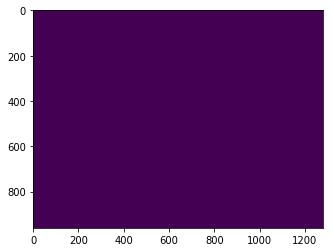

In [12]:
frame = cv2.imread("img.jpg")

lower_red = np.array([0, 0, 90])
upper_red = np.array([120, 60, 255])

# Create a mask to isolate the red color region in the RGB image
mask = cv2.inRange(frame, lower_red, upper_red)
kernel = np.ones((3, 3), np.float32) / 9

mask = cv2.erode(mask, kernel, iterations=3)
plt.imshow(mask)

In [13]:
# Find contours in the image
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# If contours are found
if contours:
   # Get the largest contour (assuming it's the blob)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Find the minimum enclosing circle for the contour
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    
    # Convert the coordinates to integers
    center = (int(x), int(y))
    radius = int(radius)
    
    # Draw the minimum enclosing circle on a color image
    image_with_circle = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # Convert to color image
    cv2.circle(image_with_circle, center, radius, (0, 0, 255), 2)  # Draw red circle
    
    print("Radius of the blob:", radius)
else:
    print("No blob found.")

No blob found.


In [14]:
plt.imshow(image_with_circle)

NameError: name 'image_with_circle' is not defined

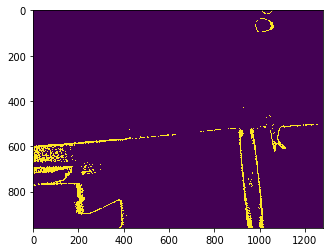

In [15]:
lower_red = np.array([0, 0, 100])
upper_red = np.array([120, 200, 255])

# Create a mask to isolate the red color region in the RGB image
mask = cv2.inRange(frame, lower_red, upper_red)
plt.imshow(mask)

In [16]:
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, red_Low, red_Up)
plt.imshow(mask)

NameError: name 'red_Low' is not defined

In [62]:


mask = cv2.erode(mask, None, iterations=2)
mask = cv2.dilate(mask, None, iterations=2)
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
centre = None
if len(cnts) > 0:
    c = max(cnts, key = cv2.contourArea)
    ((x, y), radius) = cv2.minEnclosingCircle(c)
    M = cv2.moments(c)
    centre = (int(M["m10"]/M["m00"]), int(M["m01"]/M["m00"]))
    if radius > 10:
        flag_red_ball = 1
        cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
        cv2.circle(frame, centre, 3, (0, 0, 255), -1)
cv2.imwrite('Frame.jpg', frame)

True